In [22]:
import argparse
import numpy as np
import os
import torch
import tifffile as tiff

from video_depth_anything.video_depth import VideoDepthAnything
from utils.dc_utils import read_video_frames, save_video
from torchinfo import summary
import time
import psutil
from datetime import datetime
from datasets.Kitti import KITTI
from einops import rearrange
from utils.metrics import OutlierRatio, SignedRelativeDifference_Error, AbsoluteRelativeDifference_Error, MeanSquared_Error, AbsoluteDifference_Error
from utils.metrics import Outlier, SignedRelativeDifference, AbsoluteDifference, MeanSquared, AbsoluteRelativeDifference
from utils.align import align_prediction
import matplotlib.pyplot as plt
import imageio

In [ ]:
device = 'cuda:2'
output_dir = './outputs'

encoder = 'vits'
process_single_image = True
inference_length = 32
keyframe_list = [20]
align_each_new_frame = False
skip_tmp_block = False

max_len = -1
target_fps = 10 # KITTI: 10
max_res = 1280
input_size = 518

# Datset sample 
i = 18

In [24]:
DEVICE = device if torch.cuda.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
}

video_depth_anything = VideoDepthAnything(**model_configs[encoder])
video_depth_anything.load_state_dict(torch.load(f'./checkpoints/video_depth_anything_{encoder}.pth', map_location='cpu'), strict=True)

video_depth_anything = video_depth_anything.to(DEVICE).eval()

In [25]:
dataset = KITTI(is_val=False)

sample = dataset[i]

scene_name = dataset.sample_list[i]
scene_name = scene_name['image'][0].split('/')[8] + '_cam'+dataset.sample_list[i]['cameraID']

frames = (rearrange(sample['image'].numpy(), 'b c h w -> b h w c') * 255).astype(np.uint8)
fps = 10
target_fps = 10
total_images = len(frames)


print(scene_name, 'Frames: ', total_images)
name = f'{encoder}_singleImage{str(process_single_image)}_align_each_new{align_each_new_frame}_{str(inference_length)}_{str(keyframe_list)}_{scene_name}.mp4'


2011_09_26_drive_0027_sync_cam3 Frames:  178


In [26]:
# Inference 

if process_single_image:
    depths, fps = video_depth_anything.infere_single_image(frames, target_fps, device=DEVICE, fp32=False, input_size=input_size,
                                                            inference_length=inference_length, keyframe_list=keyframe_list,
                                                            align_each_new_frame=align_each_new_frame, warmup=True, skip_tmp_block=skip_tmp_block)
else:
    depths, fps = video_depth_anything.infer_video_depth(frames, target_fps, input_size=input_size, device=DEVICE, fp32=False)

100%|██████████| 9/9 [01:10<00:00,  7.81s/it]


In [33]:
# Start Evaluating
valid_depth = sample['valid_depth'].numpy()
prediction = depths
ground_truth = sample['depth'].numpy()

if len(ground_truth) != len(prediction):
    warmup = len(ground_truth) - len(prediction)
    print(f'Assuming warm up Length of {warmup}')
    
    ground_truth = ground_truth[warmup:]
    valid_depth = valid_depth[warmup:]
    rgb_image = rearrange(sample['image'][warmup:].numpy(), 'f c h w -> f h w c')
else:
    rgb_image = rearrange(sample['image'].numpy(), 'f c h w -> f h w c')

# TODO: How to deal with clipping to certain ranges ? Momentarly we just ignore this and take max distance of dataset
align_pred, _, _ = align_prediction(prediction=prediction, ground_truth=ground_truth, valid_depth=valid_depth, max_depth=dataset.max_depth)

# Calculate Metrics
delta_1 = OutlierRatio(align_pred, ground_truth, threshold=1.25, valid_depth=valid_depth)
delta_2 = OutlierRatio(align_pred, ground_truth, threshold=1.25**2, valid_depth=valid_depth)
delta_3 = OutlierRatio(align_pred, ground_truth, threshold=1.25**3, valid_depth=valid_depth)

SRel = SignedRelativeDifference_Error(align_pred, ground_truth, valid_depth=valid_depth)
AbsRel = AbsoluteRelativeDifference_Error(align_pred, ground_truth, valid_depth=valid_depth)
MSE = MeanSquared_Error(align_pred, ground_truth, valid_depth=valid_depth)
AbsErr = AbsoluteDifference_Error(align_pred, ground_truth, valid_depth=valid_depth)

print(scene_name)
print('Delta 1: ', 1 - delta_1)
print('Delta 2: ', 1 - delta_2)
print('Delta 3: ', 1 - delta_3)
print('SRel: ', SRel)
print('AbsRel: ', AbsRel)
print('MSE: ', MSE)
print('AbsErr: ', AbsErr)

# OutlierRatio, Outlier, SignedRelative, AbsoluteRelative, MeanSquaredError, AbsoluteError

/export/data/ffeiden/git_hub_repos/Video-Depth-Anything/utils/metrics.py:115: RuntimeWarning: invalid value encountered in divide
  return backend.where(valid_depth, AbsDiff / ground_truth, 0.)


2011_09_26_drive_0027_sync_cam3
Delta 1:  0.726228531573383
Delta 2:  0.9319383488717808
Delta 3:  0.9885358236536401
SRel:  -0.00037472636533444063
AbsRel:  0.1754166195305107
MSE:  36.34141255509578
AbsErr:  3.732769344514923


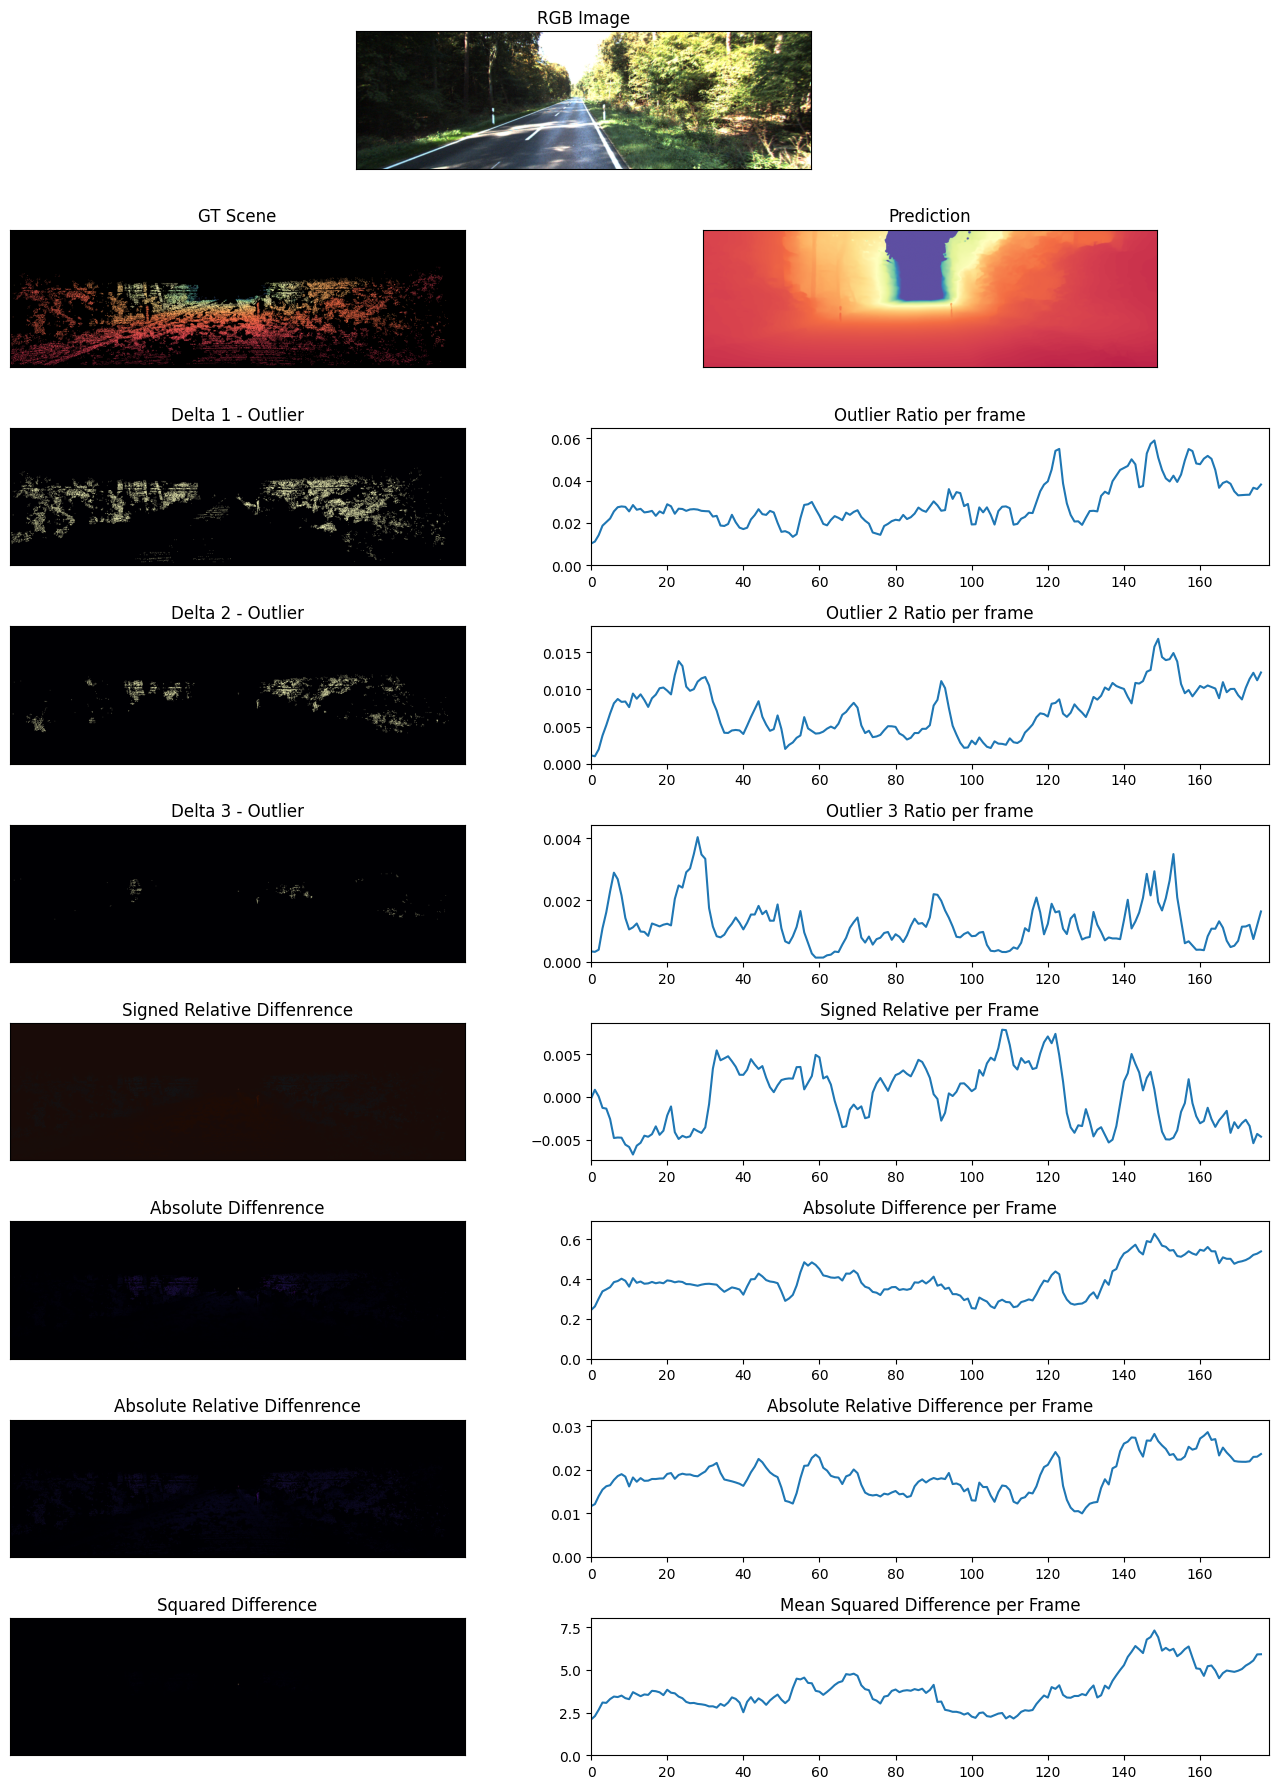

In [34]:
gt_min = ground_truth.min()
gt_max = ground_truth.max()

calc_frames = len(align_pred)
frames = np.arange(calc_frames)

# Visualise Errors and Outliers to get better feeling 
fig, axs = plt.subplots(9, 2, figsize=(14, 18))

outlier_1 = Outlier(align_pred, ground_truth, threshold=1.25, valid_depth=valid_depth).astype(bool)
outlier_1_ratio = outlier_1.mean(axis=(1,2))
outlier_1_axs = axs[2, 1]
outlier_1_axs.set_xlim(0, calc_frames)
outlier_1_axs.set_ylim(0, outlier_1_ratio.max()*1.1)
outlier_1_axs.set_title('Outlier Ratio per frame')
plot_outlier_1, = outlier_1_axs.plot([], [])

outlier_2 = Outlier(align_pred, ground_truth, threshold=1.25**2, valid_depth=valid_depth).astype(bool)
outlier_2_ratio = outlier_2.mean(axis=(1,2))
outlier_2_axs = axs[3, 1]
outlier_2_axs.set_xlim(0, calc_frames)
outlier_2_axs.set_ylim(0, outlier_2_ratio.max()*1.1)
outlier_2_axs.set_title('Outlier 2 Ratio per frame')
plot_outlier_2_axs, = outlier_2_axs.plot([], [])

outlier_3 = Outlier(align_pred, ground_truth, threshold=1.25**3, valid_depth=valid_depth).astype(bool)
outlier_3_ratio = outlier_3.mean(axis=(1,2))
outlier_3_axs = axs[4, 1]
outlier_3_axs.set_xlim(0, calc_frames)
outlier_3_axs.set_ylim(0, outlier_3_ratio.max()*1.1)
outlier_3_axs.set_title('Outlier 3 Ratio per frame')
plot_outlier_3_axs, = outlier_3_axs.plot([], [])

SRel = SignedRelativeDifference(align_pred, ground_truth, valid_depth=valid_depth)
SRel_per_image = SRel.mean(axis=(1,2))
SRel_axs = axs[5, 1]
SRel_axs.set_xlim(0, calc_frames)
SRel_axs.set_ylim(SRel_per_image.min()*1.1, SRel_per_image.max()*1.1)
SRel_axs.set_title('Signed Relative per Frame')
plot_SRel_axs, = SRel_axs.plot([], [])
SRel_min, SRel_max = SRel.min(), SRel.max()
max_val = max(np.abs(SRel_min), np.abs(SRel_max))

Abs = AbsoluteDifference(align_pred, ground_truth, valid_depth=valid_depth)
Abs_per_image = Abs.mean(axis=(1,2))
Abs_axs = axs[6, 1]
Abs_axs.set_xlim(0, calc_frames)
Abs_axs.set_ylim(0, Abs_per_image.max()*1.1)
Abs_axs.set_title('Absolute Difference per Frame')
plot_Abs_axs, = Abs_axs.plot([], [])
Abs_min, Abs_max = Abs.min(), Abs.max()

AbsRel = AbsoluteRelativeDifference(align_pred, ground_truth, valid_depth=valid_depth)
AbsRel_per_image = AbsRel.mean(axis=(1,2))
AbsRel_axs = axs[7, 1]
AbsRel_axs.set_xlim(0, calc_frames)
AbsRel_axs.set_ylim(0, AbsRel_per_image.max()*1.1)
AbsRel_axs.set_title('Absolute Relative Difference per Frame')
plot_AbsRel_axs, = AbsRel_axs.plot([], [])
AbsRel_min, AbsRel_max = AbsRel.min(), AbsRel.max()

MeanSqu = MeanSquared(align_pred, ground_truth, valid_depth=valid_depth)
MeanSqu_per_image = MeanSqu.mean(axis=(1,2))
MeanSqu_axs = axs[8, 1]
MeanSqu_axs.set_xlim(0, calc_frames)
MeanSqu_axs.set_ylim(0, MeanSqu_per_image.max()*1.1)
MeanSqu_axs.set_title('Mean Squared Difference per Frame')
plot_MeanSqu_axs, = MeanSqu_axs.plot([], [])
MSE_min, MSE_max = MeanSqu.min(), MeanSqu.max()

ground_truth_valid = np.ma.masked_where(~valid_depth, ground_truth)

# Combined first Row 
gs = axs[0, 0].get_gridspec()
for ax in axs[0]:  # axs[0, 0] und axs[0, 1]
    ax.remove()
ax_full = fig.add_subplot(gs[0, :])  # neue Achse über ganze erste Zeile

# Video Writer
writer = imageio.get_writer(os.path.join(output_dir, name), fps=fps, macro_block_size=1, codec='libx264', ffmpeg_params=['-crf', '18'])

for i in range(calc_frames):
    # RGB
    ax_full.clear()
    ax_full.imshow(rgb_image[i])
    ax_full.set_title("RGB Image")
    ax_full.set_xticks([])
    ax_full.set_yticks([])

    axs[1, 0].clear()
    cmap = plt.get_cmap('Spectral')
    cmap.set_bad(color='black')
    axs[1, 0].imshow(ground_truth_valid[i], cmap=cmap, vmin=gt_min, vmax=gt_max)
    axs[1, 0].set_title('GT Scene')
    axs[1, 0].set_xticks([])
    axs[1, 0].set_yticks([])

    axs[1, 1].clear()
    axs[1, 1].imshow(align_pred[i], cmap='Spectral', vmin=gt_min, vmax=gt_max)
    axs[1, 1].set_title('Prediction')
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])

    axs[2, 0].clear()
    axs[2, 0].imshow(outlier_1[i], cmap='magma')
    axs[2, 0].set_title('Delta 1 - Outlier')
    axs[2, 0].set_xticks([])
    axs[2, 0].set_yticks([])

    plot_outlier_1.set_data(frames[:i], outlier_1_ratio[:i])


    axs[3, 0].clear()
    axs[3, 0].imshow(outlier_2[i], cmap='magma')
    axs[3, 0].set_title('Delta 2 - Outlier')
    axs[3, 0].set_xticks([])
    axs[3, 0].set_yticks([])

    plot_outlier_2_axs.set_data(frames[:i], outlier_2_ratio[:i])

    axs[4, 0].clear()
    axs[4, 0].imshow(outlier_3[i], cmap='magma')
    axs[4, 0].set_title('Delta 3 - Outlier')
    axs[4, 0].set_xticks([])
    axs[4, 0].set_yticks([])

    plot_outlier_3_axs.set_data(frames[:i], outlier_3_ratio[:i])
    
    axs[5, 0].clear()
    axs[5, 0].imshow(SRel[i], cmap='berlin', vmin=-max_val, vmax=max_val)
    axs[5, 0].set_title('Signed Relative Diffenrence')
    axs[5, 0].set_xticks([])
    axs[5, 0].set_yticks([])

    plot_SRel_axs.set_data(frames[:i], SRel_per_image[:i])

    axs[6, 0].clear()
    axs[6, 0].imshow(Abs[i], cmap='magma', vmin=Abs_min, vmax=Abs_max)
    axs[6, 0].set_title('Absolute Diffenrence')
    axs[6, 0].set_xticks([])
    axs[6, 0].set_yticks([])

    plot_Abs_axs.set_data(frames[:i], Abs_per_image[:i])

    axs[7, 0].clear()
    axs[7, 0].imshow(AbsRel[i], cmap='magma', vmin=AbsRel_min, vmax=AbsRel_max)
    axs[7, 0].set_title('Absolute Relative Diffenrence')
    axs[7, 0].set_xticks([])
    axs[7, 0].set_yticks([])

    plot_AbsRel_axs.set_data(frames[:i], AbsRel_per_image[:i])

    axs[8, 0].clear()
    axs[8, 0].imshow(MeanSqu[i], cmap='magma', vmin=MSE_min, vmax=MSE_max)
    axs[8, 0].set_title('Squared Difference')
    axs[8, 0].set_xticks([])
    axs[8, 0].set_yticks([])

    plot_MeanSqu_axs.set_data(frames[:i], MeanSqu_per_image[:i])
    
    fig.tight_layout()

    fig.canvas.draw()
    matplotlib_frame = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
    writer.append_data(matplotlib_frame)
    
writer.close()



In [29]:
calc_frames = len(align_pred)
frames = np.arange(calc_frames)

In [32]:
print(calc_frames)
print(rgb_image.shape)

178
(147, 375, 1242, 3)


In [31]:
len(ground_truth) != len(prediction)

False